In [1]:
# Affichage pour notebook
from IPython.display import display
from tqdm import tqdm

# Calculus libraries
import numpy as np 
import pandas as pd 
import quantstats as qs 
import cvxpy as cp
import numpy as np
from pypfopt import EfficientFrontier, plotting
qs.extend_pandas()
np.random.seed(42)
pd.set_option('future.no_silent_downcasting', True)

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# 1. Pré-processing des données

### 1.1 Data to adj_price, monthly_return

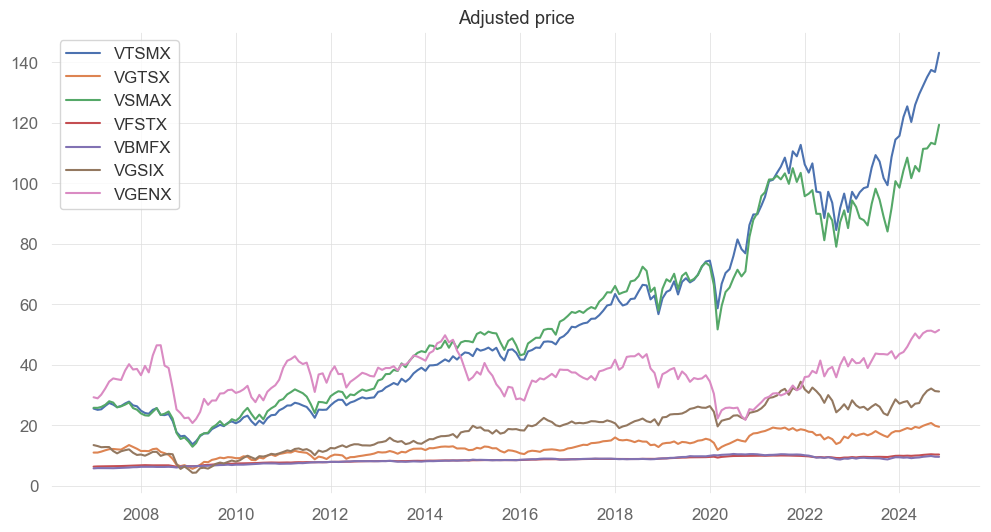

<Figure size 1000x600 with 0 Axes>

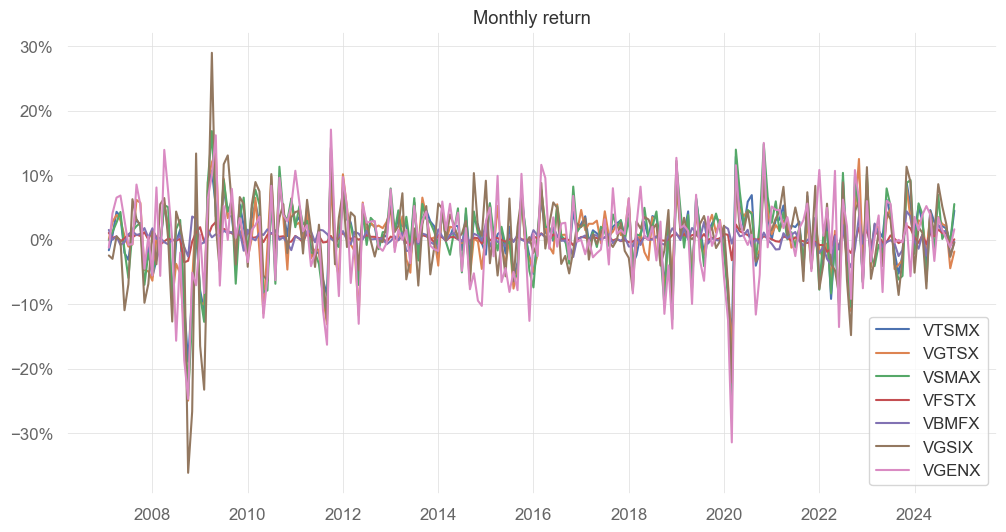

<Figure size 1000x600 with 0 Axes>

In [2]:
# 1. Lecture des données
data = pd.read_excel('Données de base.xlsx', sheet_name='Sheet 1')

# 2. Nettoyage des colonnes / lignes non utilisées
# Row 0 : NaN, Col 8 : NaN
data = data.drop(0)
data = data.drop(data.columns[8], axis=1)
# Nom des colonnes sur row 0, puis drop cette ligne
data.columns = data.iloc[0]
data = data.drop(1)

# 3. Récupération des informations
# adj price 0-6
# time 7 
# monthly returns 8-14
adj_price = data.iloc[:, 0:7]
monthly_return = data.iloc[:, 8:15]
date = data.iloc[:, 7]

# 4. Corriger les index et le nom des tableaux
# création de l'index sous le format pandas.DateTimeIndex
date = pd.to_datetime(date)
# tableau des prix ajustés
adj_price.index = date
adj_price.columns.name = 'Symbol'
adj_price.index.name = 'Date'   
# tableau des rendements mensuels
monthly_return.index = date
monthly_return.columns.name = 'Symbol'
monthly_return.index.name = 'Date'

# 5. Sauvegarde des données
# fonction qui peut réutilisé après
def save_plot_dataframe(df, title, filename, yaxis_percentage=False):
    """ Plot chaque serie temporelle dans un dataframe et sauvegarde le plot dans un fichier """
    fig = plt.figure(figsize=(12, 6))
    plt.plot(df)
    plt.title(title)
    plt.legend(df.columns)
    if yaxis_percentage:
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.show()
    plt.tight_layout()  
    fig.savefig(filename, dpi=400)
save_plot_dataframe(adj_price, 'Adjusted price', 'figures/1_1_adj_price.png')
save_plot_dataframe(monthly_return, 'Monthly return', 'figures/1_1_monthly_return.png', yaxis_percentage=True)


### 1.2 Split avec train, test dataset

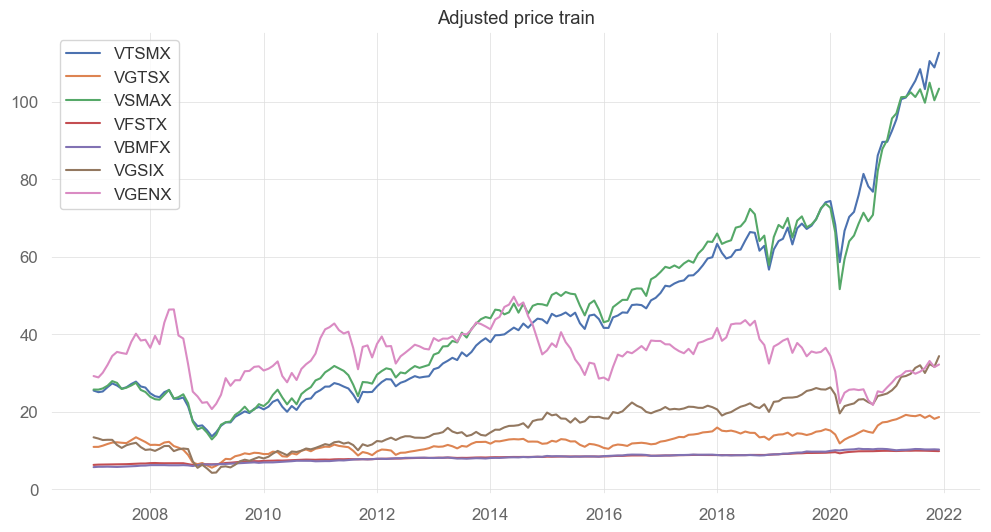

<Figure size 1000x600 with 0 Axes>

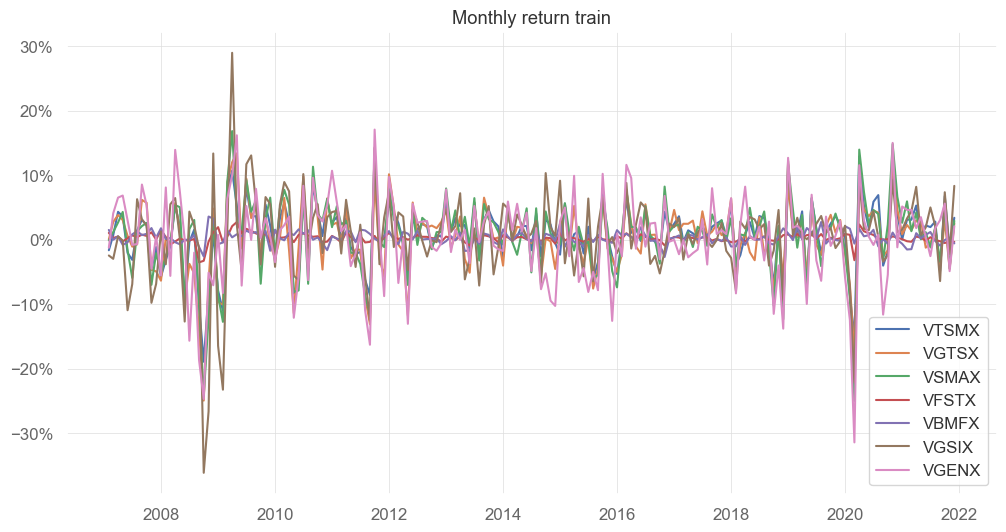

<Figure size 1000x600 with 0 Axes>

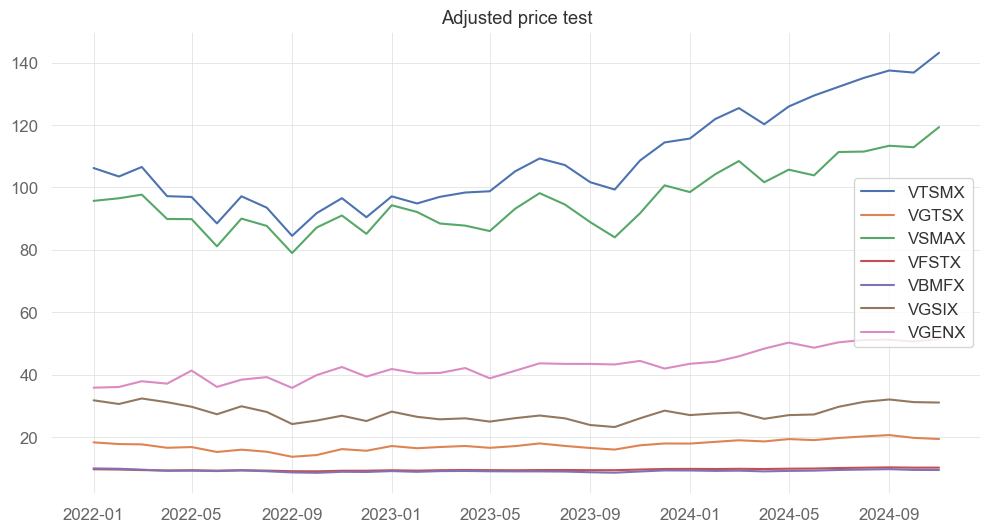

<Figure size 1000x600 with 0 Axes>

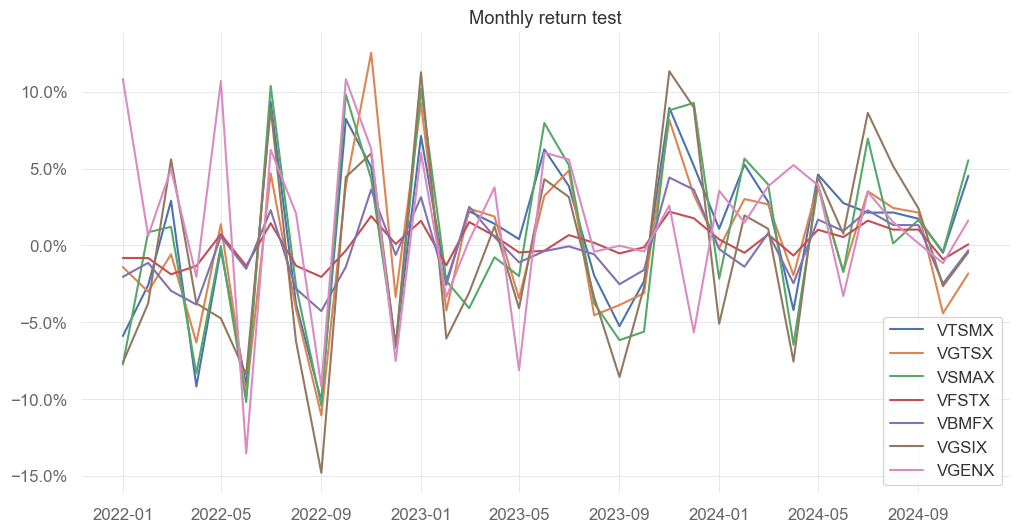

<Figure size 1000x600 with 0 Axes>

In [3]:
# 1. Choix de la date de split
split_date = '2022-01-01'

# 2. Split adj_price 
adj_price_train = adj_price[adj_price.index < split_date]
adj_price_test = adj_price[adj_price.index >= split_date]

# 3. Split monthly_return
monthly_return_train = monthly_return[monthly_return.index < split_date]
monthly_return_test = monthly_return[monthly_return.index >= split_date]

# save and plot 
save_plot_dataframe(adj_price_train, 'Adjusted price train', 'figures/1_2_adj_price_train.png')
save_plot_dataframe(monthly_return_train, 'Monthly return train', 'figures/1_2_monthly_return_train.png', yaxis_percentage=True)
save_plot_dataframe(adj_price_test, 'Adjusted price test', 'figures/1_2_adj_price_test.png')
save_plot_dataframe(monthly_return_test, 'Monthly return test', 'figures/1_2_monthly_return_test.png', yaxis_percentage=True)

# 2. Statistique descriptives sur train set

In [4]:
def plot_bar(series, title, ylabel, xlabel, filename, y_percentage=True):
    """ Bar plot d'une serie et enregistre le plot dans un fichier """
    fig = plt.figure(figsize=(10, 5)) 
    series.plot(kind='bar')
    plt.title(title)  
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if y_percentage:
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.xticks(rotation=45)
    plt.grid(axis='x')
    plt.show()
    fig.savefig(filename)
    
def compute_yield(monthly_return):
    n_months = monthly_return.shape[0]
    rendement = ((1 + monthly_return).cumprod().iloc[-1]) ** (12 / n_months) - 1
    return rendement

def compute_risk(monthly_return):
    risk = monthly_return.std() * (12 ** 0.5)
    return risk

def compute_covariance_matrix(monthly_return):
    return monthly_return.cov() * 12

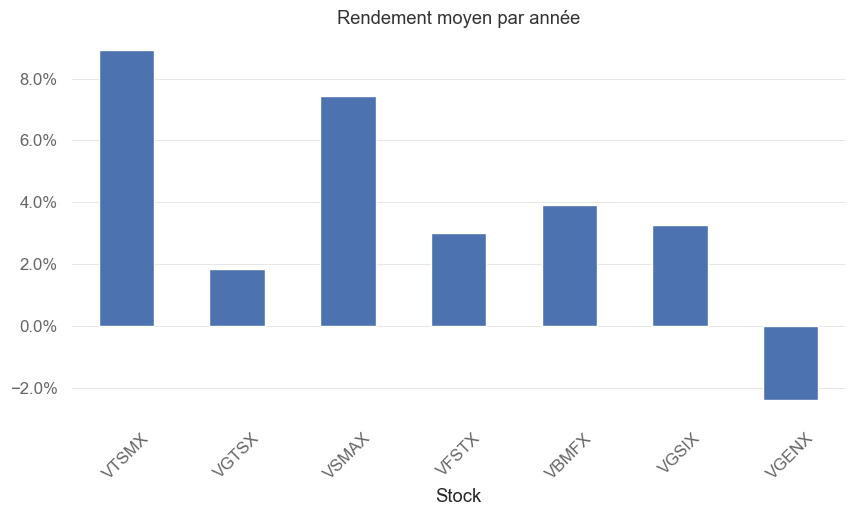

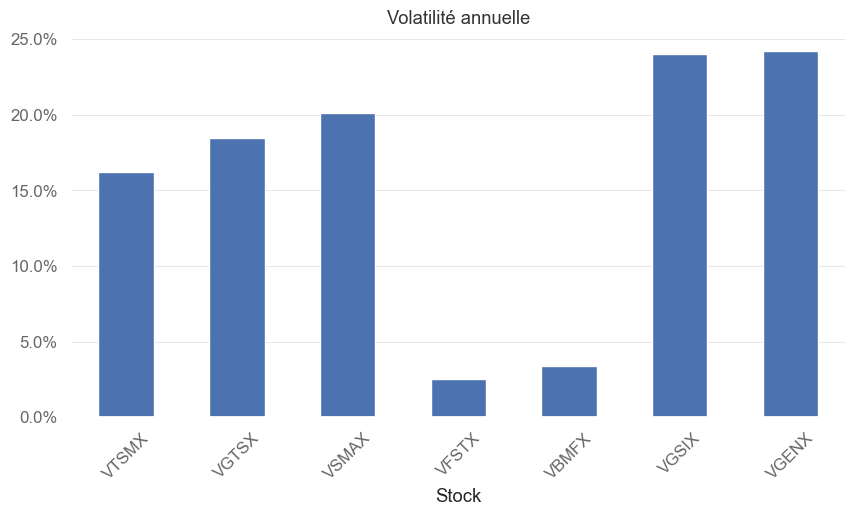

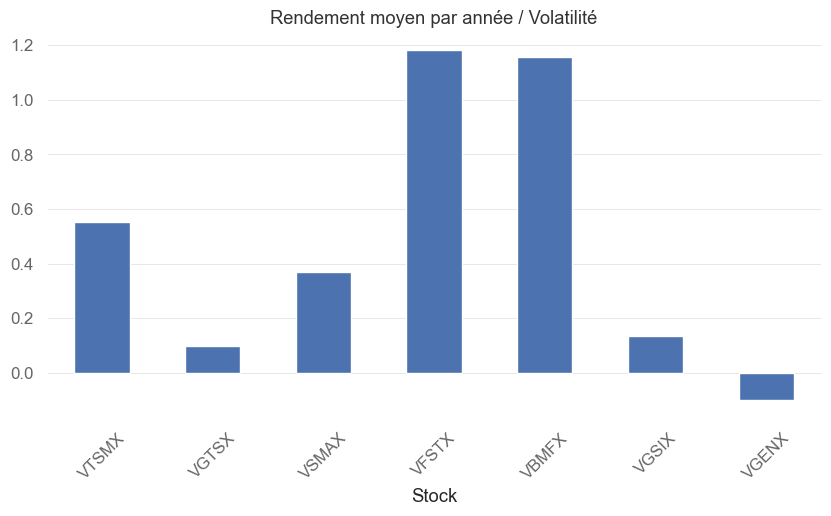

In [5]:
# 1. Calcul du rendement, volatilité et ratio de Sharpe
rendement_annuel = compute_yield(monthly_return_train)
risque_annuel = compute_risk(monthly_return_train)
cov_annuel = compute_covariance_matrix(monthly_return_train) # utile pour la formation des portefeilles
sharpe_ratio = rendement_annuel / risque_annuel

# 2. Plot des résultats
plot_bar(rendement_annuel, 'Rendement moyen par année', '', 'Stock', filename="figures/2_1_rendement")
plot_bar(risque_annuel, 'Volatilité annuelle', '', 'Stock', filename="figures/2_1_volatilite")
plot_bar(sharpe_ratio, 'Rendement moyen par année / Volatilité', '', 'Stock', filename="figures/2_1_sharp_ratio", y_percentage=False)

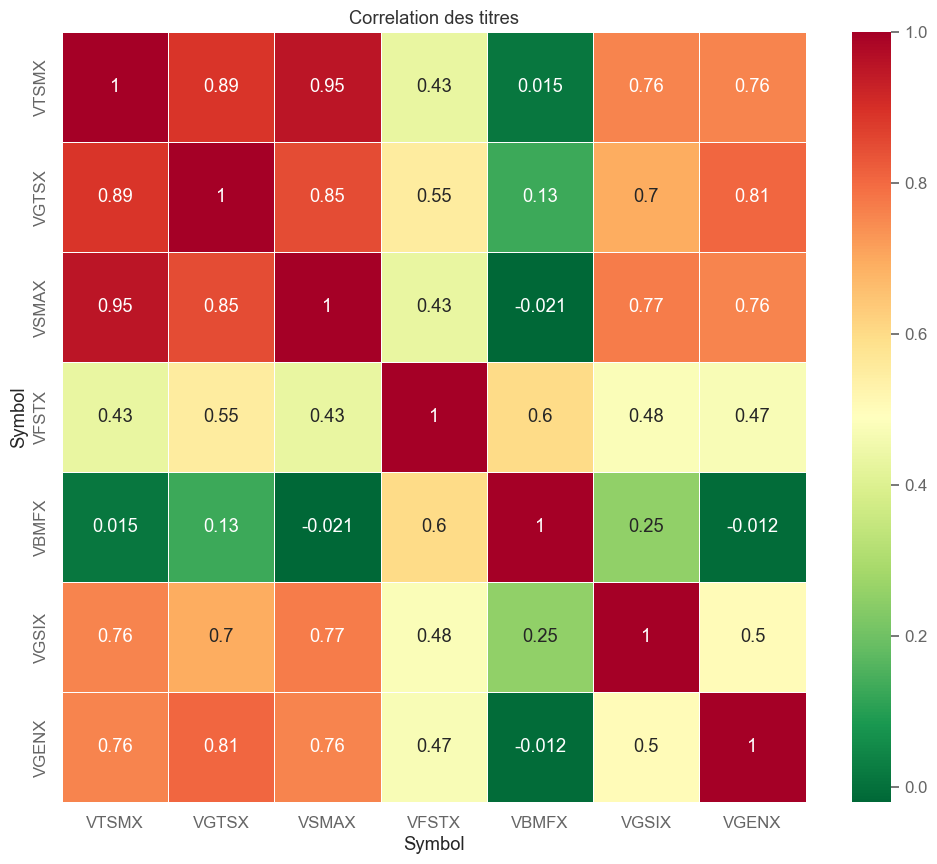

In [6]:
# 1. Calcul de la corrélation
corr = monthly_return_train.corr()

# 2. Plot de la corrélation avec heatmap de seaborn 
fig = plt.figure(figsize=(12, 10))    
sns.heatmap(corr, annot=True, cmap='RdYlGn_r', linewidths=0.5)
plt.title('Correlation des titres')
plt.show()
fig.savefig('figures/2_1_correlation.png')

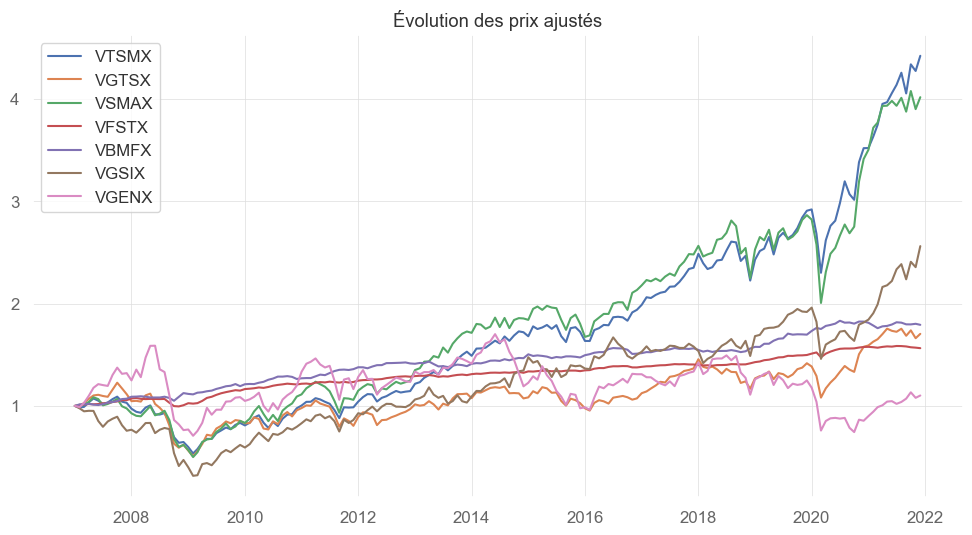

<Figure size 1000x600 with 0 Axes>

In [7]:
# Evolution prix du titre et distribution des rendements mensuels
save_plot_dataframe(adj_price_train / adj_price_train.iloc[0], 'Évolution des prix ajustés', 'figures/2_2_adj_price_train.png')

In [8]:
def plot_rendement_hist(filename, ligne, colonne, same_x=False):
    fig, axs = plt.subplots(ligne, colonne, figsize=(10, 15))
    for i in range(ligne):
        for j in range(colonne):
            if i * colonne + j >= monthly_return.shape[1]:
                break
            monthly_return.dropna().iloc[:, i * colonne + j].hist(bins=50, ax=axs[i, j])
            axs[i, j].set_title(monthly_return.columns[i * colonne + j])
            # set x between -0.2 and 0.2
            if same_x:
                axs[i, j].set_xlim(-0.2, 0.2)
            # xaxis en pourcentage
            axs[i, j].xaxis.set_major_formatter(mtick.PercentFormatter(1))
            # x axis label 
            axs[i, j].set_xlabel('Rendement mensuel')
            axs[i, j].set_ylabel('Nombre de mois')
    # title pour le plot entier
    plt.suptitle('Distribution des rendements mensuels', fontsize=30)
    plt.tight_layout()
    plt.show()
    fig.savefig(filename)

def plot_max_drawdown(returns, ligne, colonne, filename, same_y=False):
    fig, axs = plt.subplots(ligne, colonne, figsize=(10, 15))
    for i in range(ligne):
        for j in range(colonne):
            if i * colonne + j >= returns.shape[1]:
                break
            series = returns.iloc[:, i * colonne + j]
            drawdown_details = qs.stats.to_drawdown_series(series)
        
            drawdown_details = drawdown_details.astype(float).dropna()
            
            axs[i, j].plot(drawdown_details.index, drawdown_details, color='red', alpha=0.7)

            # Colorier les zones en dessous de zéro en rouge et les zones au-dessus de zéro en vert
            axs[i, j].fill_between(drawdown_details.index, drawdown_details, 0, where=drawdown_details < 0, color='red', alpha=0.3)

            axs[i, j].set_title(returns.columns[i * colonne + j])
            # set le y entre 0 et -0.7
            if same_y:
                axs[i, j].set_ylim(-0.7, 0.01)
            # yaxis en percentage
            axs[i, j].yaxis.set_major_formatter(mtick.PercentFormatter(1))
            # x axis label
            axs[i, j].set_xlabel('Date')
            axs[i, j].set_ylabel('Drawdown')
    # title pour le plot entier
    plt.suptitle('Maximum Drawdown', fontsize=30)
    plt.tight_layout()
    plt.show()
    fig.savefig(filename)

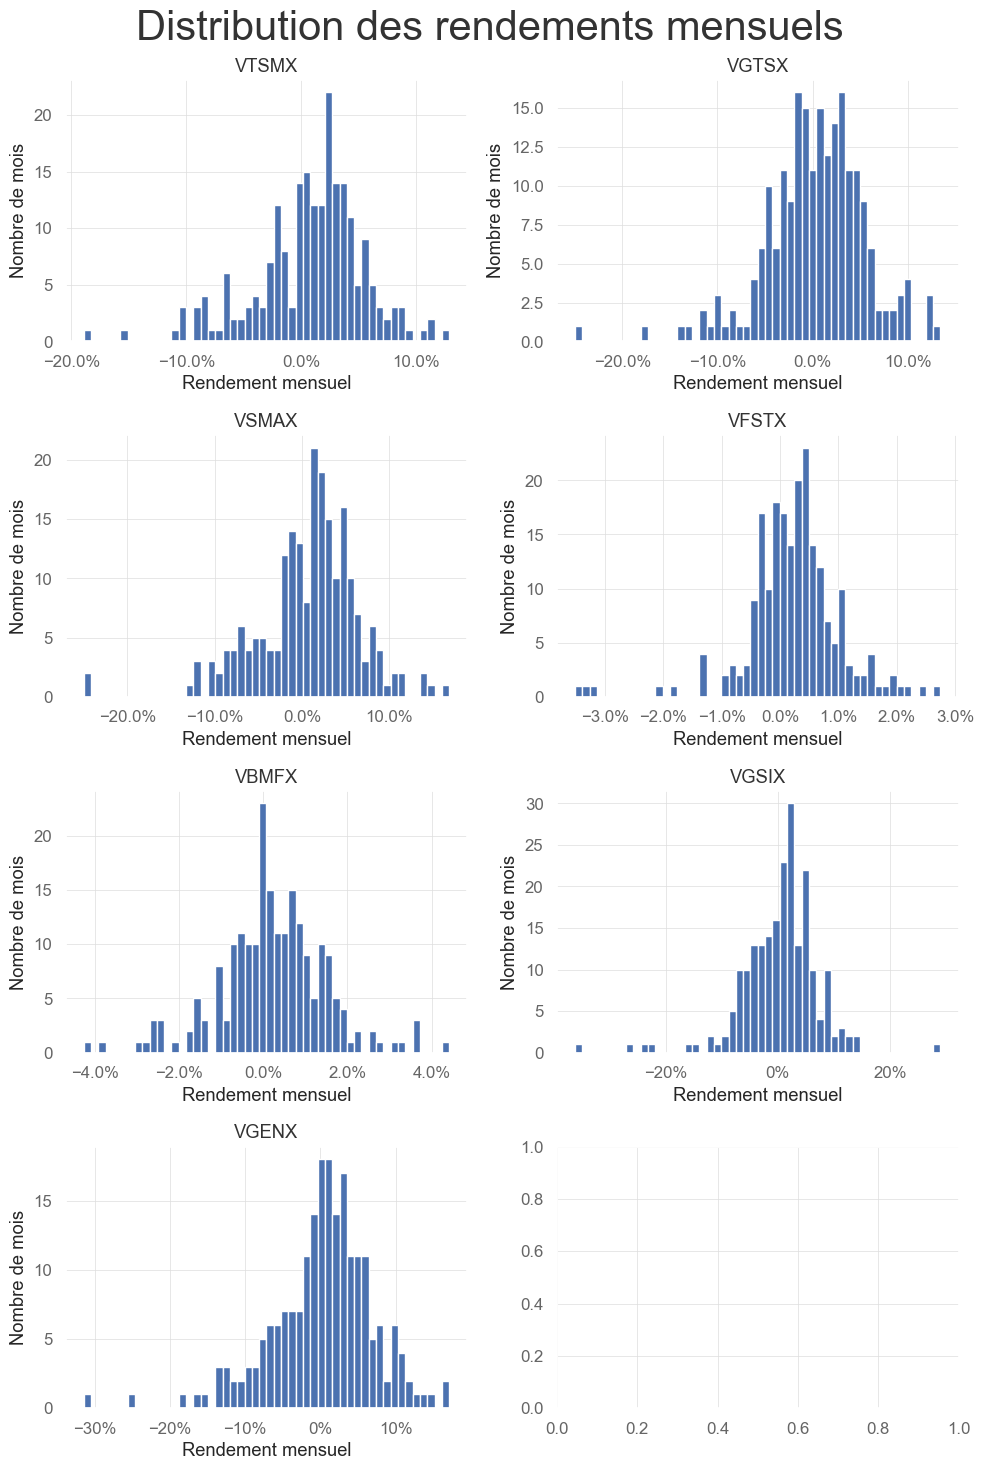

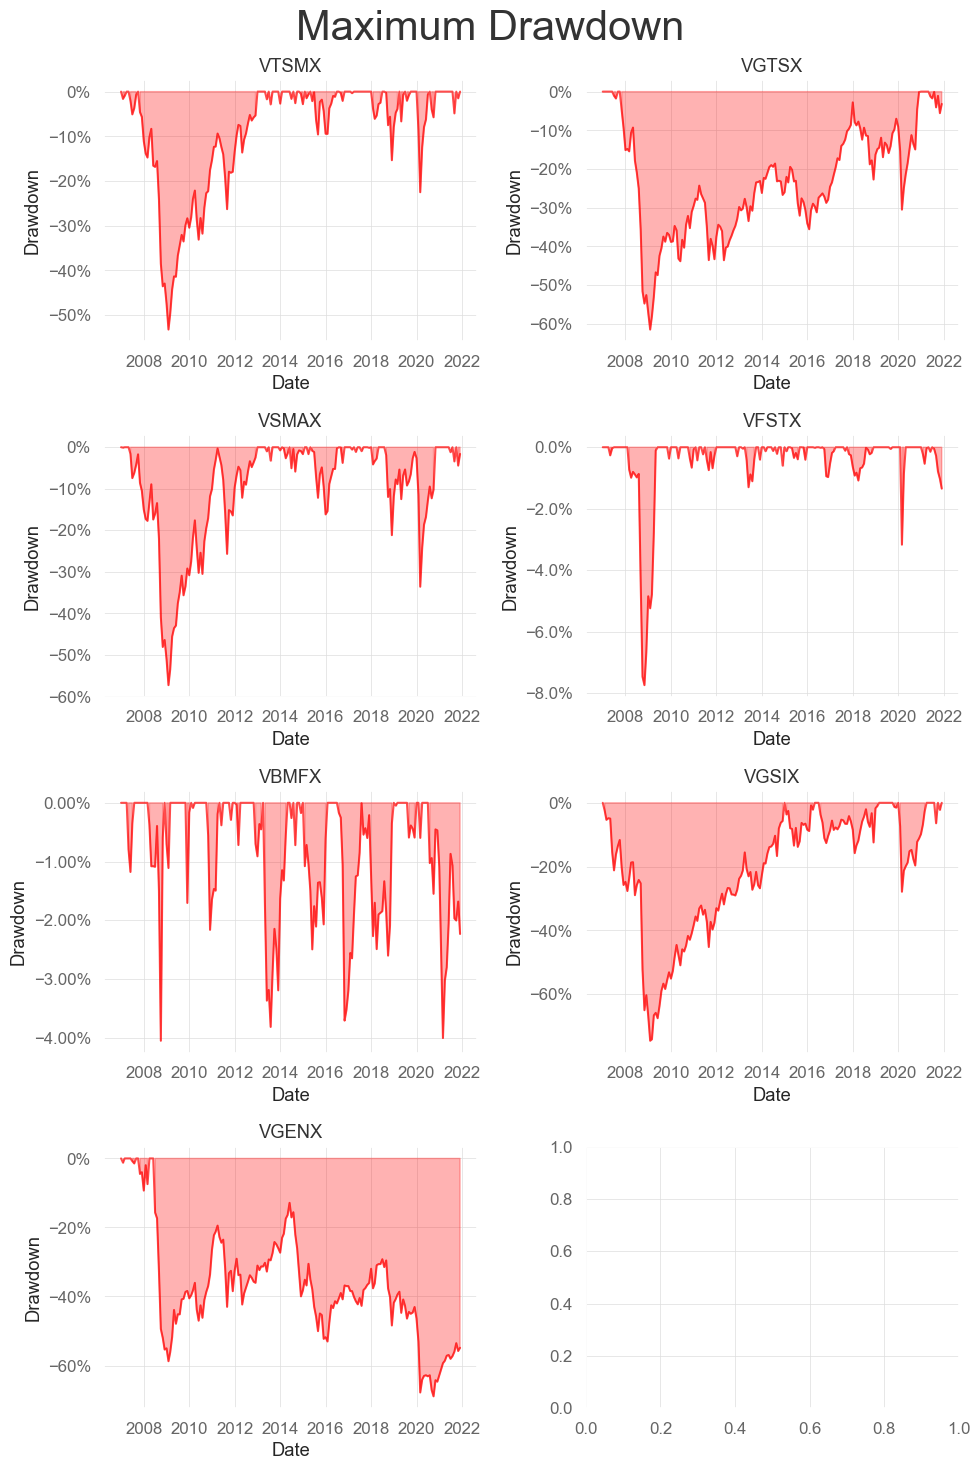

In [9]:
# 1. Plot des distributions des rendements mensuels
# # Uncomment pour avoir les rendements sur la même échelle
# plot_rendement_hist(same_x=True)
plot_rendement_hist(filename='figures/2_2_distributions des rendements mensuels', ligne=4, colonne=2, same_x=False)
    
# 2. Plot des maximum drawdown
# # Uncomment pour avoir le même y pour tous les plots
# plot_max_drawdown(monthly_return_train, ligne=2, colonne=4, same_y=True)
plot_max_drawdown(monthly_return_train, ligne=4, colonne=2, filename='figures/2_2_maximum_drawdown', same_y=False)

# 3. Optimisation de portefeuille

### 3.1 Portefeuille 1 : Variance minimale, contrainte > 0

In [10]:
# 1. Création d'un dataframe pour les poids 
weights_df = pd.DataFrame(columns=adj_price_train.columns)
weights_df

Symbol,VTSMX,VGTSX,VSMAX,VFSTX,VBMFX,VGSIX,VGENX


In [11]:
# fonction pour calculer reutilisable pour le probleme de minimisation de variance avec contraintes
def compute_variance_weights(n_assets, cov, lower_bound_constraint, upper_bound_constraint):

    # creation des variables 
    weights = cp.Variable(n_assets)
    
    # creation de la fonction objective
    portfolio_risk = cp.quad_form(weights, cov)
    objective = cp.Minimize(portfolio_risk)

    # creation des contraintes 
    constraints = [cp.sum(weights) == 1, weights >= lower_bound_constraint, weights <= upper_bound_constraint]
    
    # creation et resolution du probleme 
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    return weights.value, np.sqrt(portfolio_risk.value)

# fonction pour plot camembert les poids d'un portefeuille 
def plot_camembert(weights_list, title, filename):
    fig = plt.figure(figsize=(7, 7))
    plt.pie(weights_list, labels=weights_df.columns, autopct='%1.1f%%')
    plt.title(title)
    plt.tight_layout()
    plt.show()    
    fig.savefig(filename)

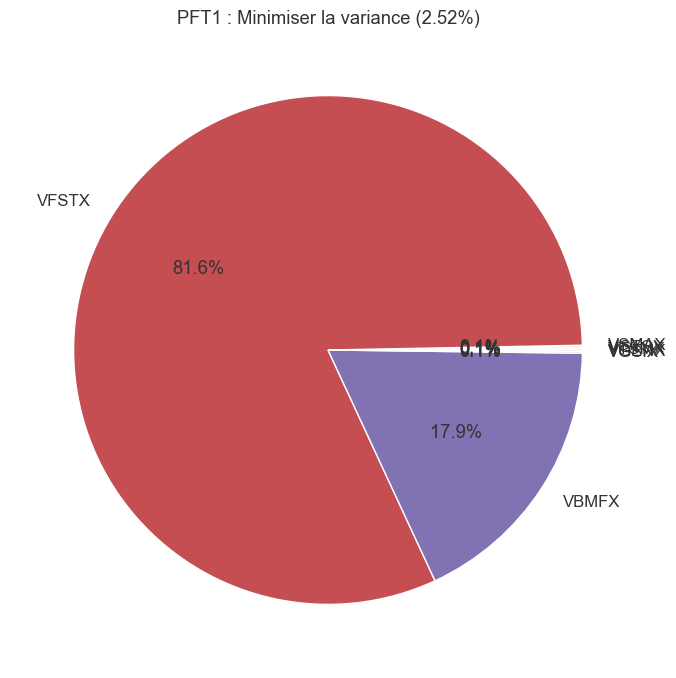

In [12]:
# 1. Calcul des poids pour minimiser la variance
weights, variance = compute_variance_weights(len(adj_price_train.columns), 
                                             cov_annuel,
                                             lower_bound_constraint=0.001,
                                             upper_bound_constraint=1)

# 3. Sauvegarde des poids et plot des poids 
weights_df.loc['PTF1'] = weights
plot_camembert(weights, f'PFT1 : Minimiser la variance ({variance * 100:.2f}%)', filename='figures/3_1_PTF1.png')

### 3.1 Portefeuille 2 : Variance minimale, 0.3 > contrainte > 0.05

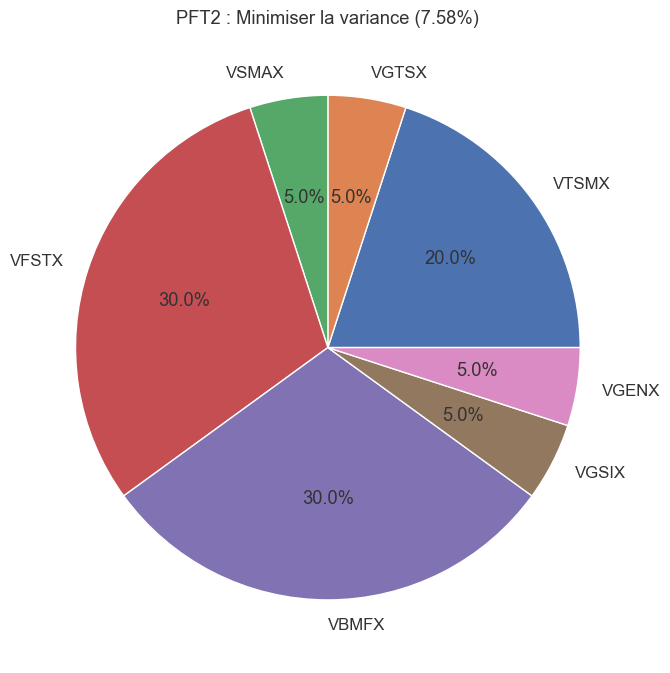

In [13]:
# 1. Calcul des poids pour minimiser la variance
weights, variance = compute_variance_weights(len(adj_price_train.columns), 
                                             cov_annuel,
                                             lower_bound_constraint=0.05,
                                             upper_bound_constraint=0.30)

# 3. Sauvegarde des poids et plot des poids
weights_df.loc['PTF2'] = weights
plot_camembert(weights, f'PFT2 : Minimiser la variance ({variance * 100:.2f}%)', filename='figures/3_1_PTF2.png')

### 3.3 Frontière efficiente 

/var/folders/zy/ycwjsmz943s7ly3gn8lrp_v00000gn/T/ipykernel_5077/2237041262.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(txt, (risque_annuel[i], rendement_annuel[i]))


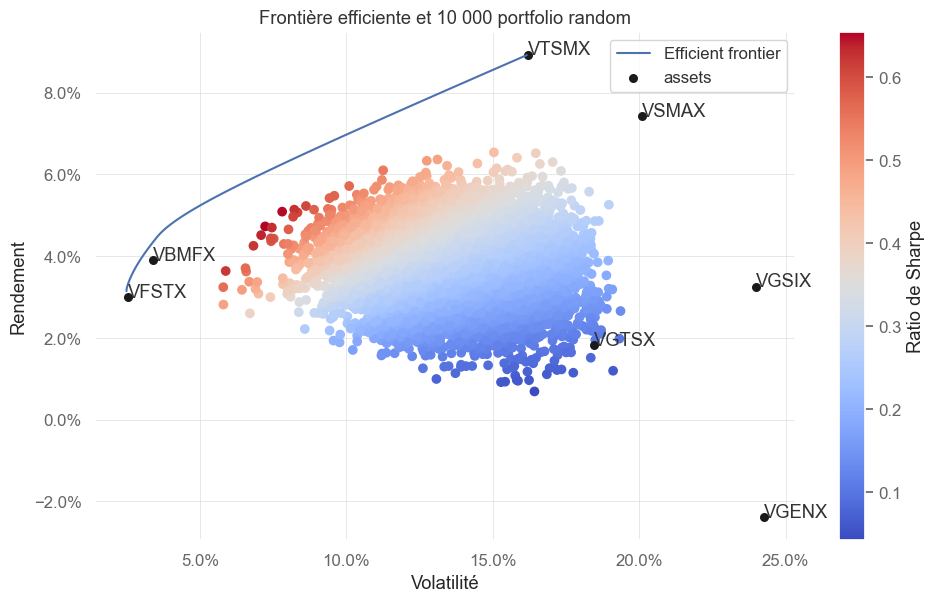

In [14]:
# 0. Fixer la seed pour la reproductibilité
np.random.seed(42)

# 1. Générer n-portfeuilles aléatoires
# génération des poids 
n_samples = 10000
weights = np.random.rand(n_samples, monthly_return_train.shape[1])
weights = weights / weights.sum(axis=1)[:, None]
# calcul du rendement et la volatilité des portefeuilles
returns = np.sum(weights * rendement_annuel.values, axis=1)
volatilities = np.sqrt(np.diag(weights @ cov_annuel @ weights.T))

# 2. Calcul de la frontiere efficiente à partir du rendement et de la covariance
ef = EfficientFrontier(rendement_annuel, cov_annuel)

# 3. Plot des portefeuilles aléatoires
fig, ax = plt.subplots()
plt.scatter(volatilities, returns, c=returns/volatilities, marker='o', cmap='coolwarm')

# 4. Plot de la frontiere efficiente et les actifs
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
for i, txt in enumerate(rendement_annuel.index):
    ax.annotate(txt, (risque_annuel[i], rendement_annuel[i]))

# fig settings
plt.title('Frontière efficiente et 10 000 portfolio random')
plt.xlabel('Volatilité')
plt.ylabel('Rendement')
plt.colorbar(label='Ratio de Sharpe')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
# save fig 
fig.savefig('figures/3_2_frontiere_efficiente.png')

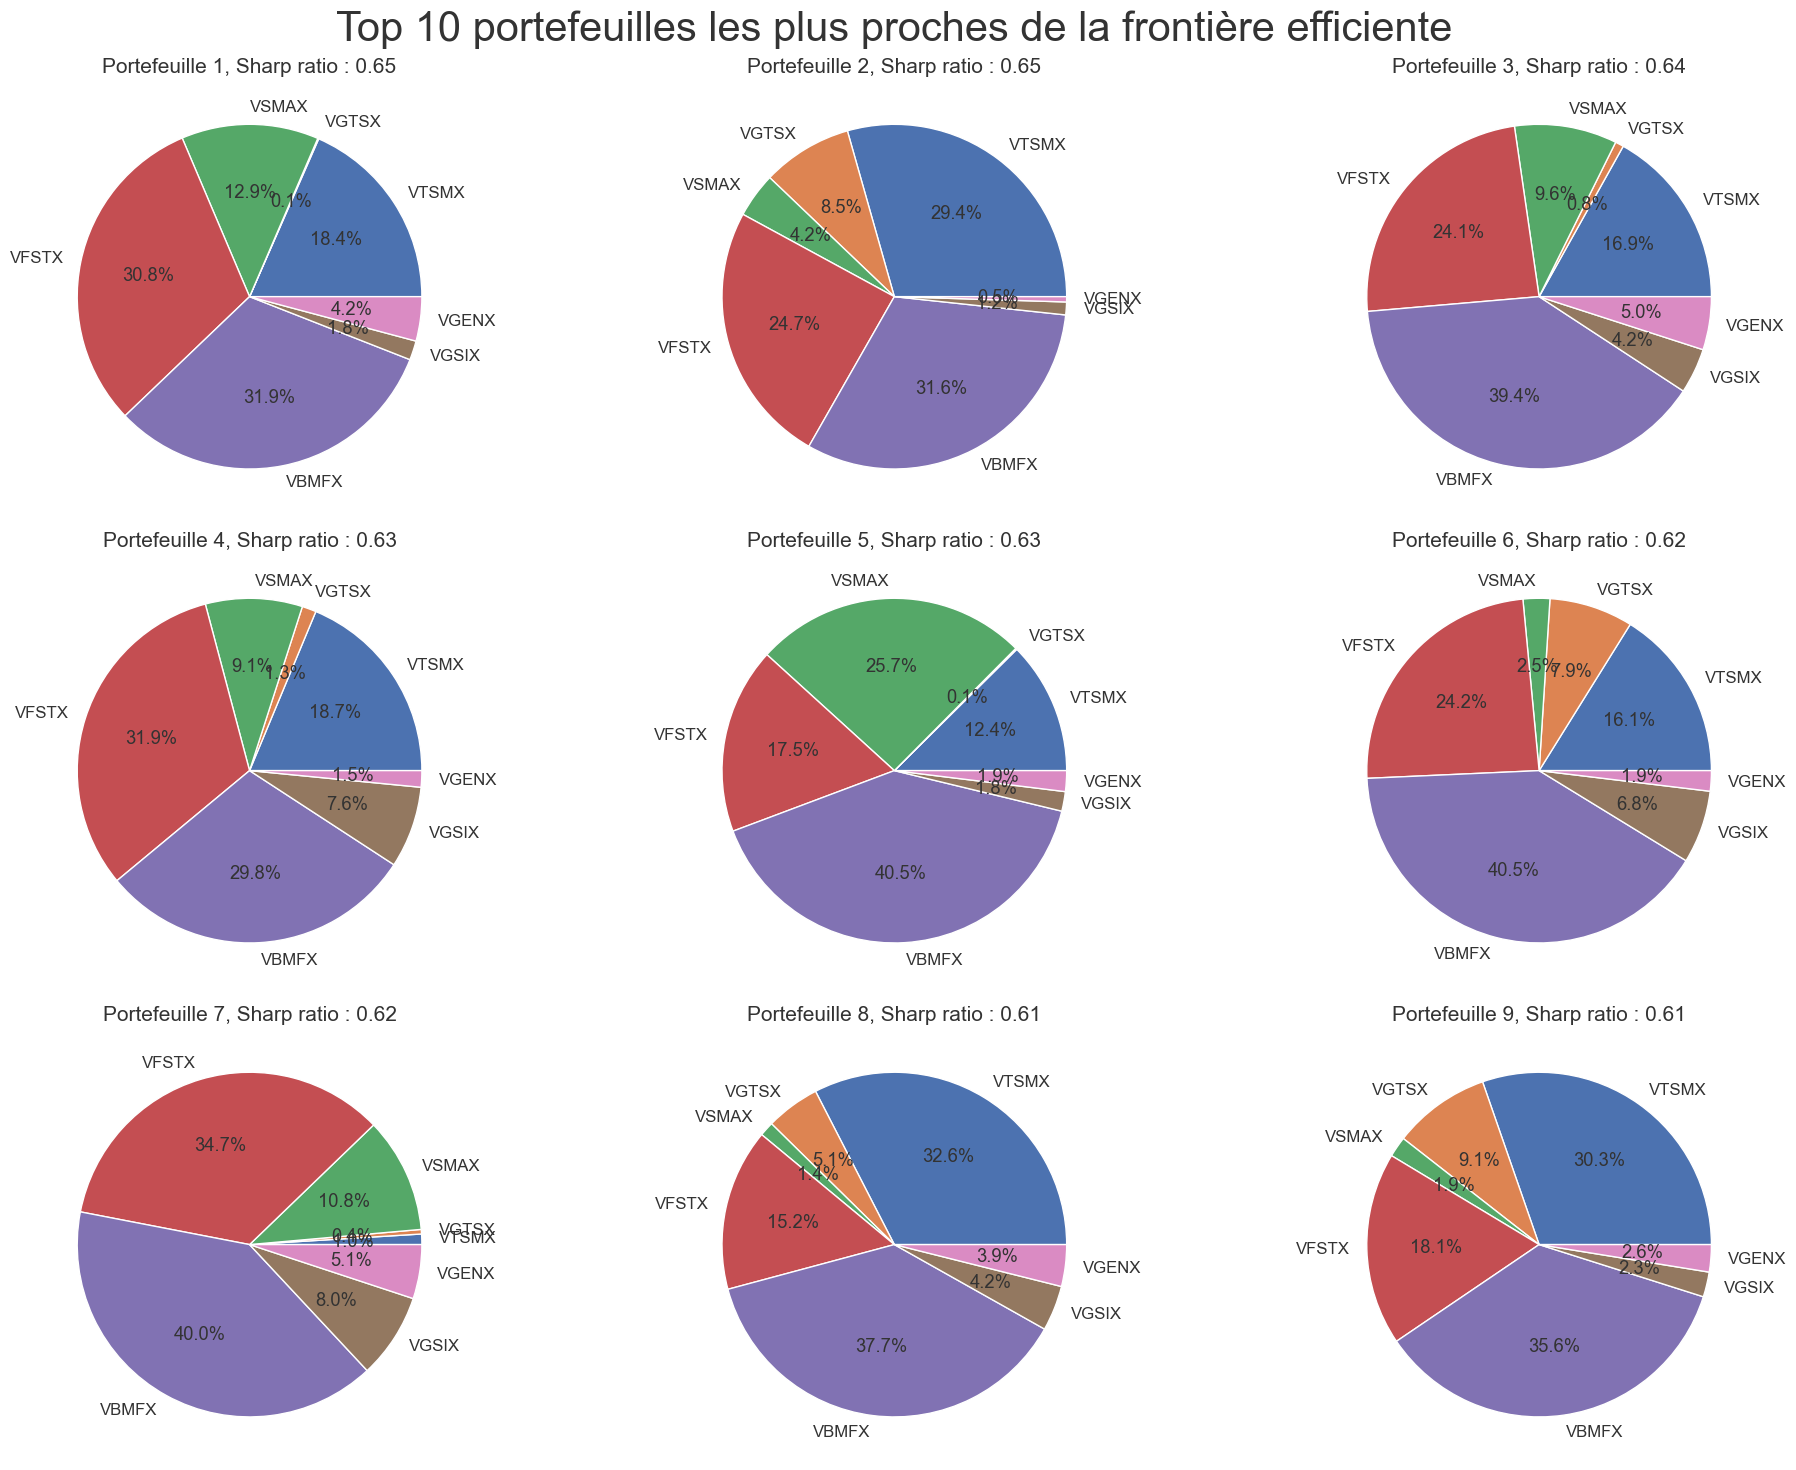

In [15]:
# 1. Calcul ratio sharp pour garder les 10 meilleurs portefeuilles les plus proches de la frontiere efficiente 
sharp_ratio = returns / volatilities

# 2. Trier et garder les top 10 meilleurs sharp ratio 
top_10 = np.argsort(sharp_ratio)[::-1][:10]
weights = weights[top_10]

# 3. Plotting 
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
for i in range(3):
    for j in range(3):
        if i * 3 + j >= weights.shape[0]:
            break
        # pie plot on each subplot
        axs[i, j].pie(weights[i * 3 + j], labels=rendement_annuel.index, autopct='%1.1f%%')
        axs[i, j].set_title(f'Portefeuille {i * 3 + j + 1}, Sharp ratio : {sharp_ratio[top_10][i * 3 + j]:.2f}', fontsize=15)
plt.suptitle('Top 10 portefeuilles les plus proches de la frontière efficiente', fontsize=30)
plt.tight_layout()
plt.show()
fig.savefig('figures/3_2_top_10_portefeuilles.png')

### 3.1 Portefeuille 3 : Sharp ratio maximal, contrainte > 0

In [16]:
# fonction pour calculer le meilleur portefeuille avec le ratio de sharpe le plus élevé avec un rendement cible
def compute_sharp_weights(n_assets, cov, yield_, yield_target, lower_bound_constraint, upper_bound_constraint):

    # creation des variables 
    weights = cp.Variable(n_assets)
    
    # creation de la fonction objective
    portfolio_risk = cp.quad_form(weights, cov)
    objective = cp.Minimize(portfolio_risk)

    # creation des contraintes 
    constraints = [cp.sum(weights) == 1, 
                   weights >= lower_bound_constraint, 
                   weights <= upper_bound_constraint,
                   cp.sum(weights @ yield_) >= yield_target]
    
    # creation et resolution du probleme 
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    if weights.value is None:
        return None, None, None
    
    return weights.value, np.sqrt(portfolio_risk.value), cp.sum(weights @ yield_).value

# fonction qui calcule les poids optimaux pour maximiser le ratio de sharpe en iterant sur plusieurs rendements cibles
def compute_max_sharp_weights(cov, rendement, cols, lower_bound_constraint, upper_bound_constraint):
    
    sharp_ratios, weights_list = [], []
    
    for yield_target in np.linspace(0.01, 0.09, 50):

        # compute weights
        weights, variance, return_ = compute_sharp_weights(len(cols), 
                                                            cov,
                                                            rendement.values,
                                                            yield_target,
                                                            lower_bound_constraint=lower_bound_constraint,
                                                            upper_bound_constraint=upper_bound_constraint)

        # store weights and plot weights
        # print(weights)
        # print(variance, return_)
        if return_ is not None:
            sharp_ratios.append(return_ / variance)
            weights_list.append(weights)
            # print(return_ / variance, '\n')
    if len(sharp_ratios) == 0:
        raise ValueError('No solution found')
            
    argmax_sharp = np.argmax(sharp_ratios)
    weight_opt = weights_list[argmax_sharp]

    return weight_opt, sharp_ratios[argmax_sharp]

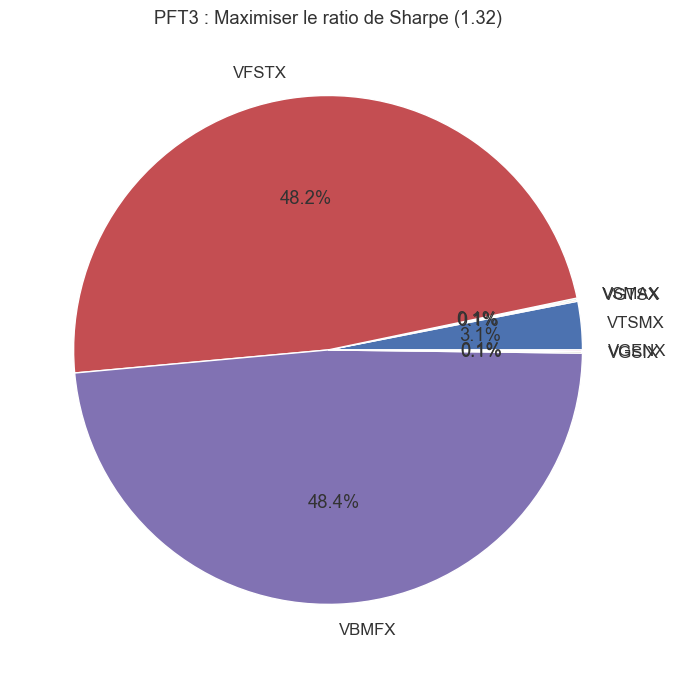

In [17]:
# 1. Compute max sharp ratio
weights, sharp_ratio = compute_max_sharp_weights(cov_annuel, 
                                                 rendement_annuel, 
                                                 adj_price_train.columns, 
                                                 lower_bound_constraint=0.001, 
                                                 upper_bound_constraint=1)

# 2. Save and plot
weights_df.loc['PTF3'] = weights
plot_camembert(weights, f'PFT3 : Maximiser le ratio de Sharpe ({sharp_ratio:.2f})', filename='figures/3_3_PTF3.png')

### 3.2 Portefeuille 4 : Sharp ratio maximal, 0.3 > contrainte > 0.05

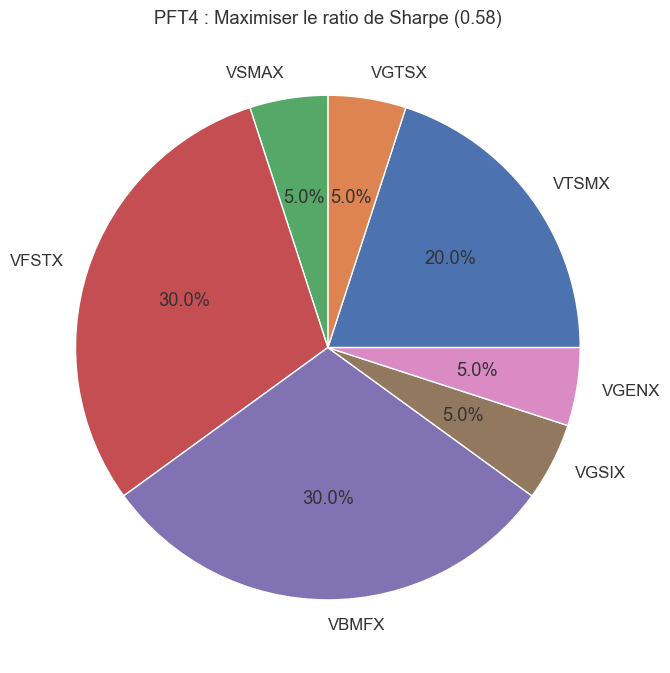

In [18]:
# 1. compute max sharp ratio
weights, sharp_ratio = compute_max_sharp_weights(cov_annuel, 
                                                 rendement_annuel, 
                                                 adj_price_train.columns, 
                                                 lower_bound_constraint=0.05, 
                                                 upper_bound_constraint=0.3)

# 2. Save and plot
weights_df.loc['PTF4'] = weights
plot_camembert(weights, f'PFT4 : Maximiser le ratio de Sharpe ({sharp_ratio:.2f})', filename='figures/3_3_PTF4.png')

# 4. Essai sur test set 

### 4.1 Portfolio benchmark

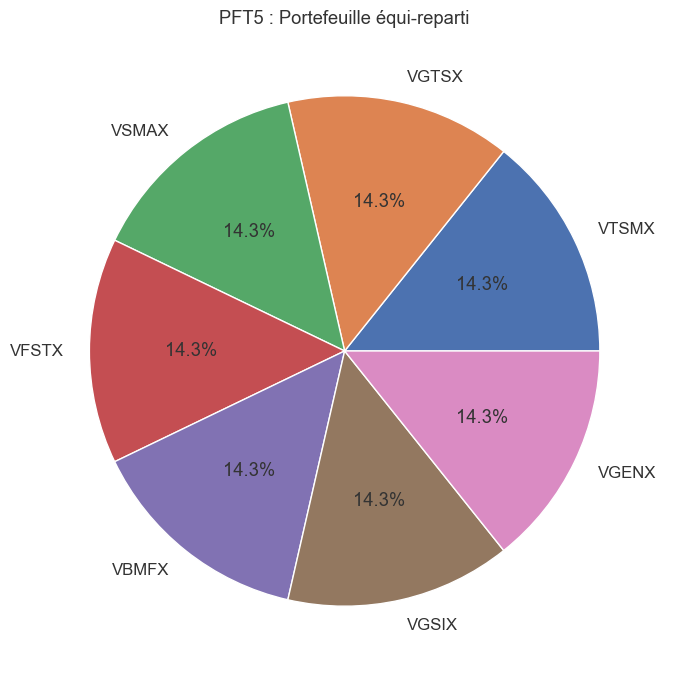

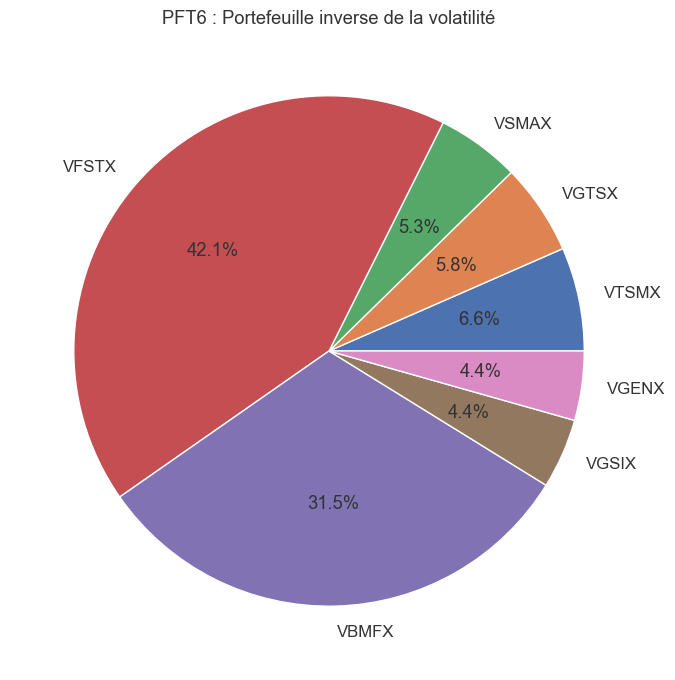

In [19]:
# 1. portfeuille equi-reparti 
weights = np.ones(len(adj_price_train.columns)) / len(adj_price_train.columns)
weights_df.loc['PTF5'] = weights

# 2. portefeuille inverse de la volatilité
inverse = 1 / risque_annuel 
weights = inverse / inverse.sum() # normalisation pour que la somme des poids soit égale à 1
weights_df.loc['PTF6'] = weights

# Plotting
plot_camembert(weights_df.loc['PTF5'], 'PFT5 : Portefeuille équi-reparti', filename='figures/4_1_PTF5.png')
plot_camembert(weights_df.loc['PTF6'], 'PFT6 : Portefeuille inverse de la volatilité', filename='figures/4_1_PTF6.png')

### 4.2 Backtesting des stratégies

In [20]:
# Preparation du dataframe qui va conserver les poids après rebalancement

# 1. Création d'un dataframe pour les poids sur le test set
cols = pd.MultiIndex.from_product([weights_df.index, adj_price_train.columns])
weights_test_df = pd.DataFrame(columns=cols, index=adj_price_test.index)

# 2. Pas de rebalancement pour PTF5 et PTF6, tous les poids sont les mêmes
for portofolio in ['PTF5', 'PTF6']:
    weights_test_df.loc[:, (portofolio, slice(None))] = weights_df.loc[portofolio].values

# 3. Calcul des dates de rebalancement
rebalancing_dates = pd.date_range(start=weights_test_df.index[0], end=weights_test_df.index[-1], freq='4MS')
display(rebalancing_dates)

# 4. Remplir toutes les portefeuilles pour rebalancing date[0]
day_0 = rebalancing_dates[0]
for portofolio in weights_df.index:
    weights_test_df.loc[day_0, (portofolio, slice(None))] = weights_df.loc[portofolio].values
display(weights_test_df)

DatetimeIndex(['2022-01-01', '2022-05-01', '2022-09-01', '2023-01-01',
               '2023-05-01', '2023-09-01', '2024-01-01', '2024-05-01',
               '2024-09-01'],
              dtype='datetime64[ns]', freq='4MS')

PTF1                                                  PTF2        \
Symbol      VTSMX  VGTSX  VSMAX     VFSTX     VBMFX  VGSIX  VGENX VTSMX VGTSX   
Date                                                                            
2022-01-01  0.001  0.001  0.001  0.816104  0.178896  0.001  0.001   0.2  0.05   
2022-02-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2022-03-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2022-04-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2022-05-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2022-06-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2022-07-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2022-08-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2022-09-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2022-10-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2022-11-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2022-12-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-01-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-02-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-03-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-04-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-05-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-06-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-07-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-08-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-09-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-10-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-11-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2023-12-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-01-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-02-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-03-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-04-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-05-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-06-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-07-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-08-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-09-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-10-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   
2024-11-01    NaN    NaN    NaN       NaN       NaN    NaN    NaN   NaN   NaN   

                  ...      PTF5                          PTF6           \
Symbol     VSMAX  ...     VBMFX     VGSIX     VGENX     VTSMX    VGTSX   
Date              ...                                                    
2022-01-01  0.05  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-02-01   NaN  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-03-01   NaN  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-04-01   NaN  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-05-01   NaN  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-06-01   NaN  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-07-01   NaN  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-08-01   NaN  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-09-01   NaN  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-10-01   NaN  ...  0.142857  0.142857  0.1

In [21]:
# Concaténation de monthly return test and train 
monthly_return_all = pd.concat([monthly_return_train, monthly_return_test]).dropna()
display(monthly_return_all)

Symbol,VTSMX,VGTSX,VSMAX,VFSTX,VBMFX,VGSIX,VGENX
Date,,,,,,,
2007-02-01,-0.016256,0.000561,-0.000898,0.010616,0.015252,-0.024431,-0.01219
2007-03-01,0.006999,0.027625,0.011912,0.002736,-0.000008,-0.029596,0.041039
2007-04-01,0.043347,0.038487,0.026792,0.005098,0.005203,0.005206,0.065374
2007-05-01,0.036218,0.03047,0.04316,-0.002645,-0.007936,-0.001142,0.068624
2007-06-01,-0.020417,0.006085,-0.016143,0.002284,-0.003866,-0.109346,0.030313
...,...,...,...,...,...,...,...
2024-07-01,0.021299,0.035237,0.069472,0.016114,0.022789,0.086258,0.034709
2024-08-01,0.021413,0.024349,0.001253,0.010265,0.01331,0.05161,0.015156
2024-09-01,0.017343,0.02137,0.016583,0.010279,0.013147,0.024067,0.001367


In [22]:
# Rebalancement des portefeuilles pour chaque date de rebalancement
for rebalancing_date in tqdm(rebalancing_dates[1:]):

    # on se limite a 180 mois = 15 ans
    data = monthly_return_all.loc[:rebalancing_date] # on s'assure de pas voir dans le futur 
    data = data.iloc[-180:]
    
    # compute risk and return 
    rendement = compute_yield(data)
    risk = compute_risk(data)
    cov = data.cov()
    
    # PTF1
    weights, variance = compute_variance_weights(len(data.columns), cov, 0.001, 1)
    weights_test_df.loc[rebalancing_date, ('PTF1', slice(None))] = weights
    
    # PTF2
    weights, variance = compute_variance_weights(len(data.columns), cov, 0.05, 0.3)
    weights_test_df.loc[rebalancing_date, ('PTF2', slice(None))] = weights

    # PTF3
    weights, sharp_ratio = compute_max_sharp_weights(cov, rendement, data.columns, 0.001, 1)
    weights_test_df.loc[rebalancing_date, ('PTF3', slice(None))] = weights
    
    # PTF4
    weights, sharp_ratio = compute_max_sharp_weights(cov, rendement, data.columns, 0.05, 0.3)
    weights_test_df.loc[rebalancing_date, ('PTF4', slice(None))] = weights
    
# fullfill weights_test_df vers le bas 
weights_test_df.fillna(method='ffill', inplace=True)
display(weights_test_df)

100%|██████████| 8/8 [00:01<00:00,  6.95it/s]
/var/folders/zy/ycwjsmz943s7ly3gn8lrp_v00000gn/T/ipykernel_5077/3565047990.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weights_test_df.fillna(method='ffill', inplace=True)


PTF1                                                  PTF2        \
Symbol      VTSMX  VGTSX  VSMAX     VFSTX     VBMFX  VGSIX  VGENX VTSMX VGTSX   
Date                                                                            
2022-01-01  0.001  0.001  0.001  0.816104  0.178896  0.001  0.001   0.2  0.05   
2022-02-01  0.001  0.001  0.001  0.816104  0.178896  0.001  0.001   0.2  0.05   
2022-03-01  0.001  0.001  0.001  0.816104  0.178896  0.001  0.001   0.2  0.05   
2022-04-01  0.001  0.001  0.001  0.816104  0.178896  0.001  0.001   0.2  0.05   
2022-05-01  0.001  0.001  0.001  0.892126  0.102874  0.001  0.001   0.2  0.05   
2022-06-01  0.001  0.001  0.001  0.892126  0.102874  0.001  0.001   0.2  0.05   
2022-07-01  0.001  0.001  0.001  0.892126  0.102874  0.001  0.001   0.2  0.05   
2022-08-01  0.001  0.001  0.001  0.892126  0.102874  0.001  0.001   0.2  0.05   
2022-09-01  0.001  0.001  0.001   0.96647   0.02853  0.001  0.001   0.2  0.05   
2022-10-01  0.001  0.001  0.001   0.96647   0.02853  0.001  0.001   0.2  0.05   
2022-11-01  0.001  0.001  0.001   0.96647   0.02853  0.001  0.001   0.2  0.05   
2022-12-01  0.001  0.001  0.001   0.96647   0.02853  0.001  0.001   0.2  0.05   
2023-01-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-02-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-03-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-04-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-05-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-06-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-07-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-08-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-09-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-10-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-11-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2023-12-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-01-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-02-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-03-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-04-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-05-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-06-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-07-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-08-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-09-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-10-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   
2024-11-01  0.001  0.001  0.001     0.994     0.001  0.001  0.001   0.2  0.05   

                  ...      PTF5                          PTF6           \
Symbol     VSMAX  ...     VBMFX     VGSIX     VGENX     VTSMX    VGTSX   
Date              ...                                                    
2022-01-01  0.05  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-02-01  0.05  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-03-01  0.05  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-04-01  0.05  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-05-01  0.05  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-06-01  0.05  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-07-01  0.05  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-08-01  0.05  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-09-01  0.05  ...  0.142857  0.142857  0.142857  0.065677  0.05767   
2022-10-01  0.05  ...  0.142857  0.142857  0.1

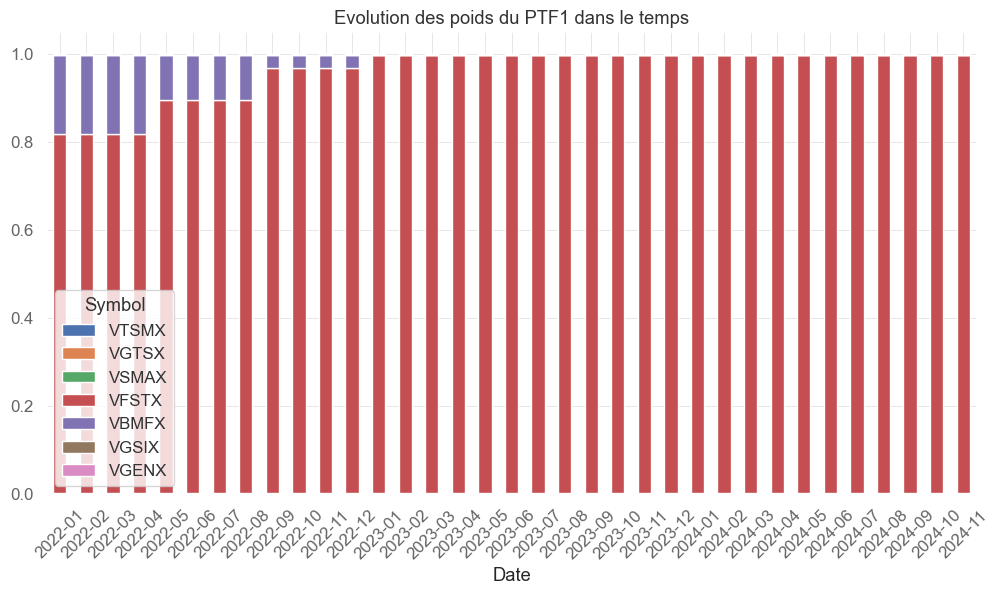

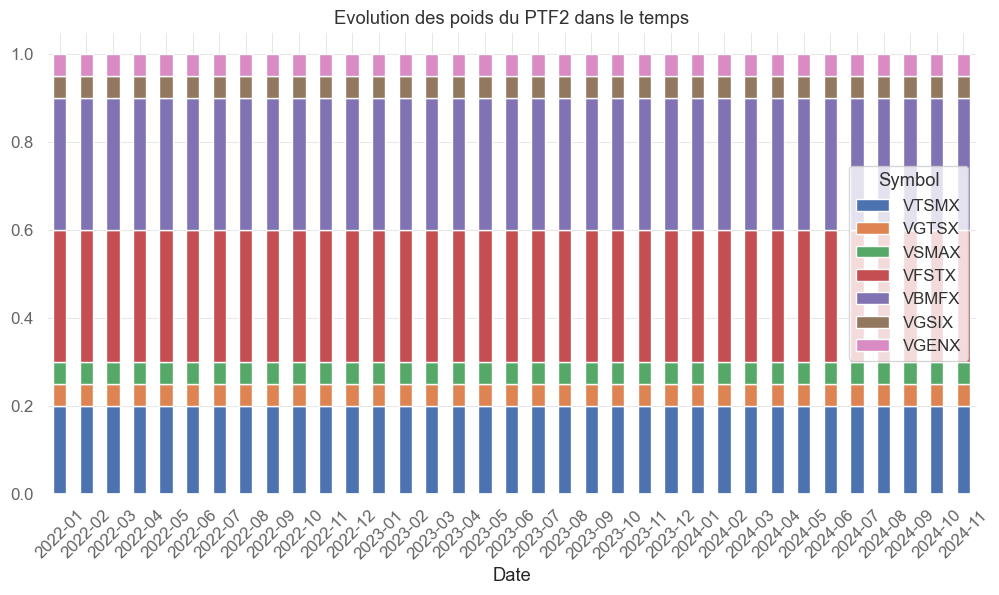

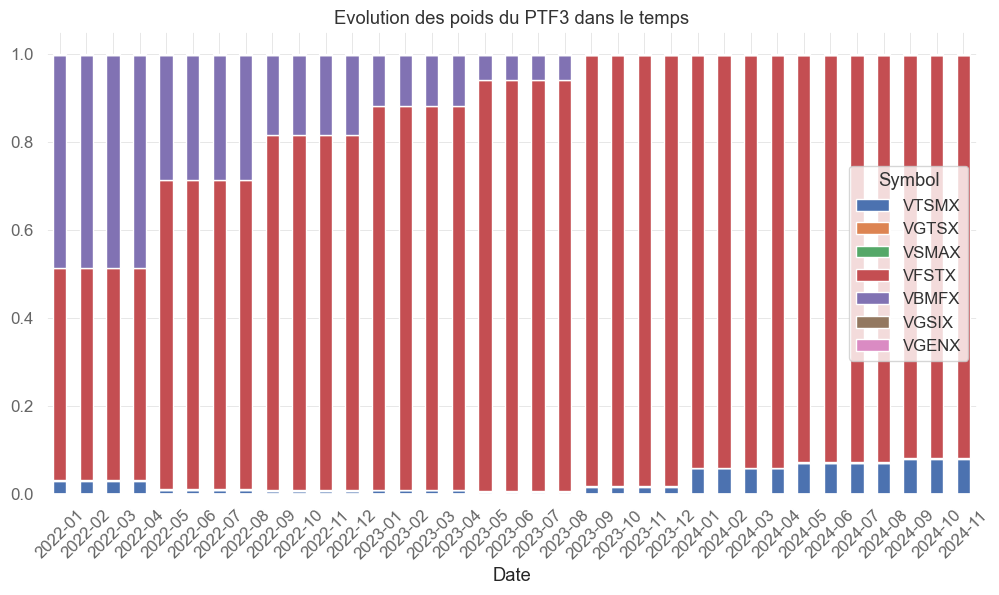

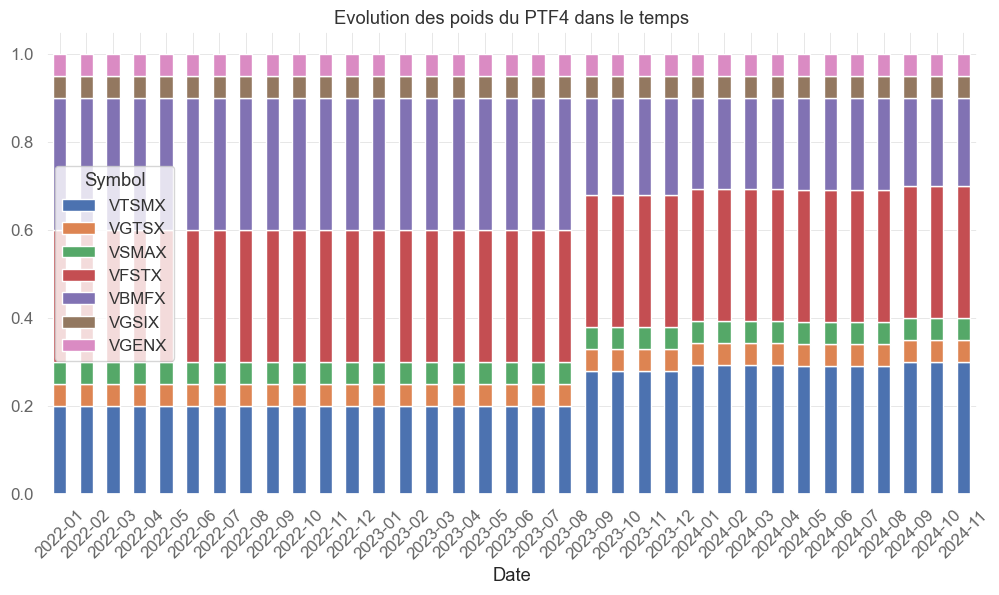

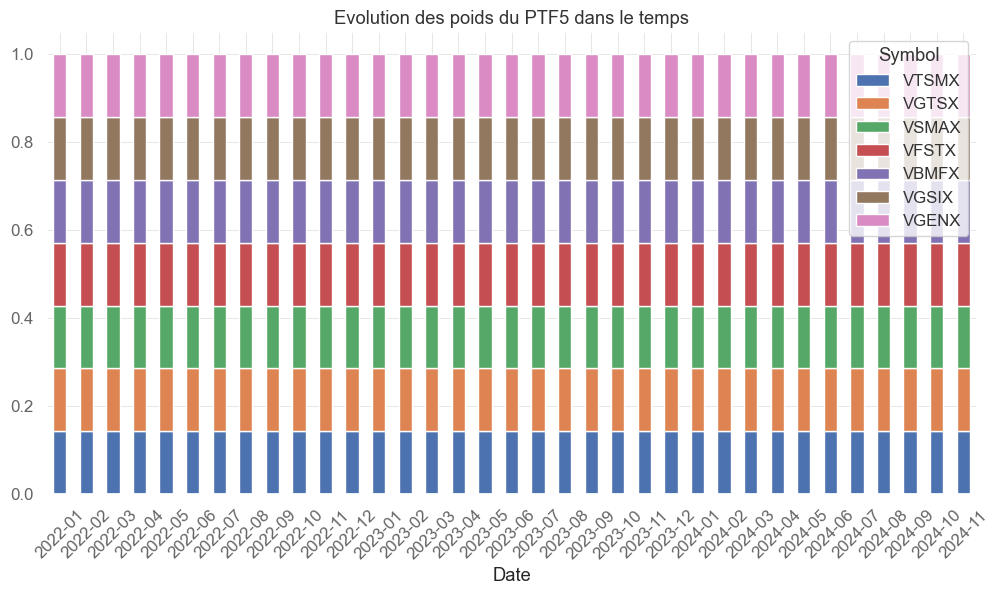

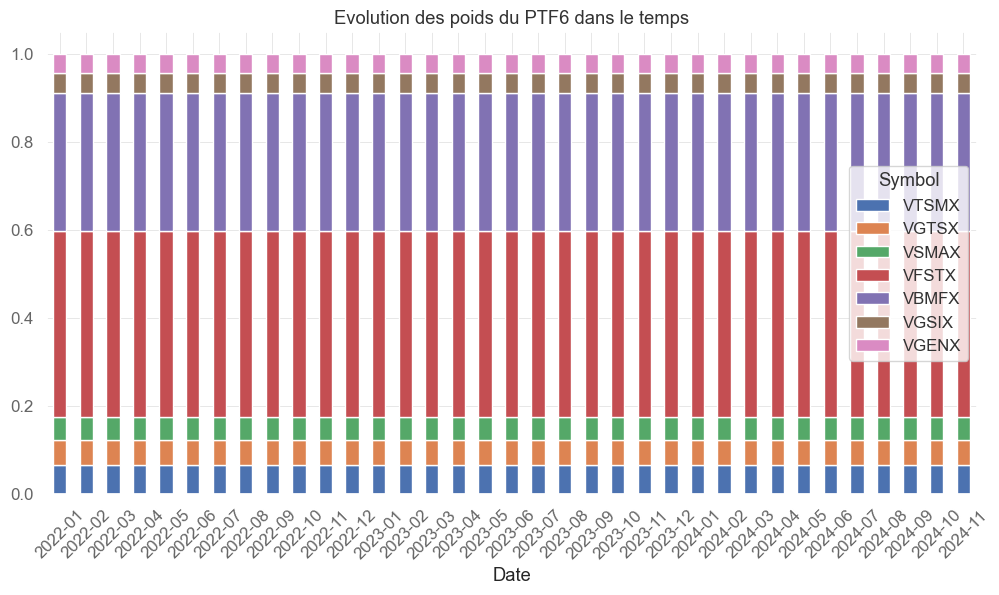

In [23]:
# fonction pour plot les poids des portefeuilles dans le temps
def plot_evolution_portefeuille(weights_df_plot, pft_name, title, filename):
    fig, ax = plt.subplots(figsize=(12, 6))
    weights_df_plot[pft_name].plot(kind='bar', stacked=True, ax=ax)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    fig.savefig(filename)

weights_df_plot = weights_test_df.copy()
weights_df_plot.index = weights_df_plot.index.strftime('%Y-%m')
plot_evolution_portefeuille(weights_df_plot, 'PTF1', 'Evolution des poids du PTF1 dans le temps', 'figures/4_2_evolution_PTF1.png')
plot_evolution_portefeuille(weights_df_plot, 'PTF2', 'Evolution des poids du PTF2 dans le temps', 'figures/4_2_evolution_PTF2.png')
plot_evolution_portefeuille(weights_df_plot, 'PTF3', 'Evolution des poids du PTF3 dans le temps', 'figures/4_2_evolution_PTF3.png')
plot_evolution_portefeuille(weights_df_plot, 'PTF4', 'Evolution des poids du PTF4 dans le temps', 'figures/4_2_evolution_PTF4.png')
plot_evolution_portefeuille(weights_df_plot, 'PTF5', 'Evolution des poids du PTF5 dans le temps', 'figures/4_2_evolution_PTF5.png')
plot_evolution_portefeuille(weights_df_plot, 'PTF6', 'Evolution des poids du PTF6 dans le temps', 'figures/4_2_evolution_PTF6.png')

### 4.3 Calcul des indicateurs pour chaque portefeuille

/var/folders/zy/ycwjsmz943s7ly3gn8lrp_v00000gn/T/ipykernel_5077/3366369087.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rendement_portefeuille_test_df = rendement_test_df.groupby(level=0, axis=1).sum()


PTF1    0.010774
PTF2    0.018504
PTF3    0.006873
PTF4    0.026057
PTF5    0.028888
PTF6    0.009783
Name: 2024-11-01 00:00:00, dtype: float64

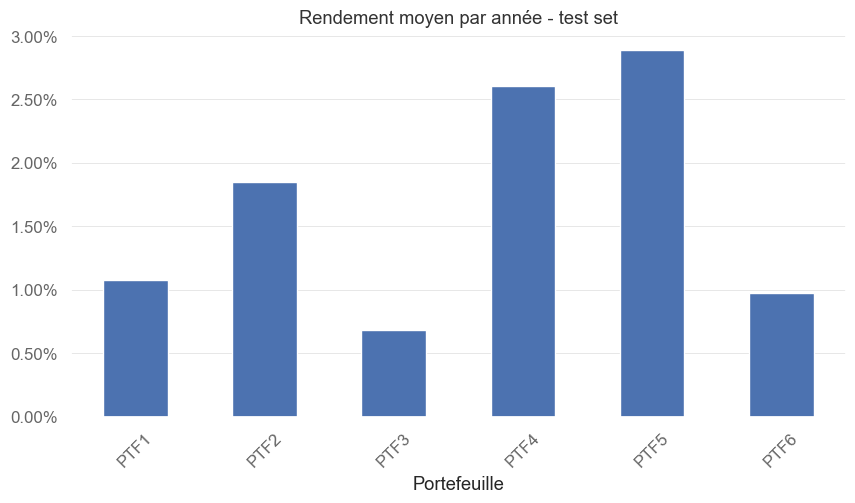

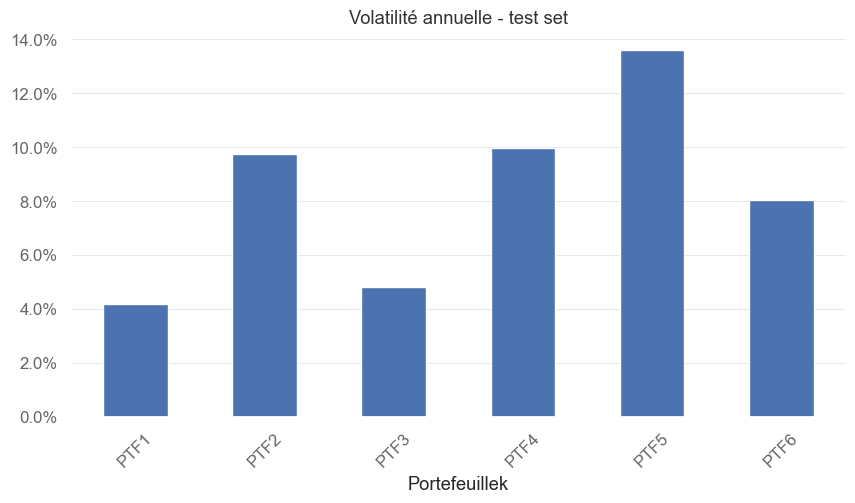

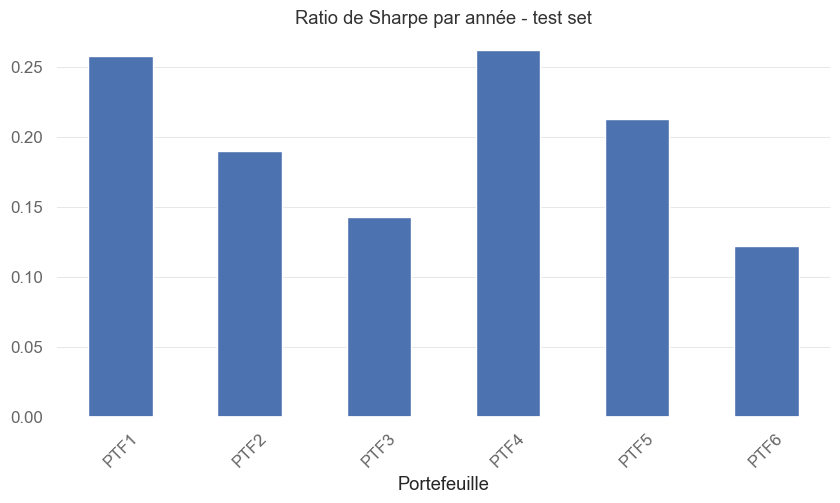

In [24]:
# multiplier par le remdenet sur le test set
rendement_test_df = weights_test_df * monthly_return_test

# sommer pour chaque stock mais pas pour chaque portefeuille
# rendement_test_df = rendement_test_df.sum(axis=1, level=1)
rendement_portefeuille_test_df = rendement_test_df.groupby(level=0, axis=1).sum()
    
# formule = monthly_return.cumprod() - 1
rendement_ = compute_yield(rendement_portefeuille_test_df)
display(rendement_)
plot_bar(rendement_, 'Rendement moyen par année - test set', '', 'Portefeuille', filename="figures/4_3_rendement")

# volatilité annuelle, group by year
# get one value per year, first value of year 
risk_ = compute_risk(rendement_portefeuille_test_df)
plot_bar(risk_, 'Volatilité annuelle - test set', '', 'Portefeuillek', filename="figures/4_3_volatilite")

# ratio rendement / risk 
sharpe_ratio = rendement_ / risk_
plot_bar(sharpe_ratio, 'Ratio de Sharpe par année - test set', '', 'Portefeuille', filename="figures/4_3_sharp_ratio", y_percentage=False)

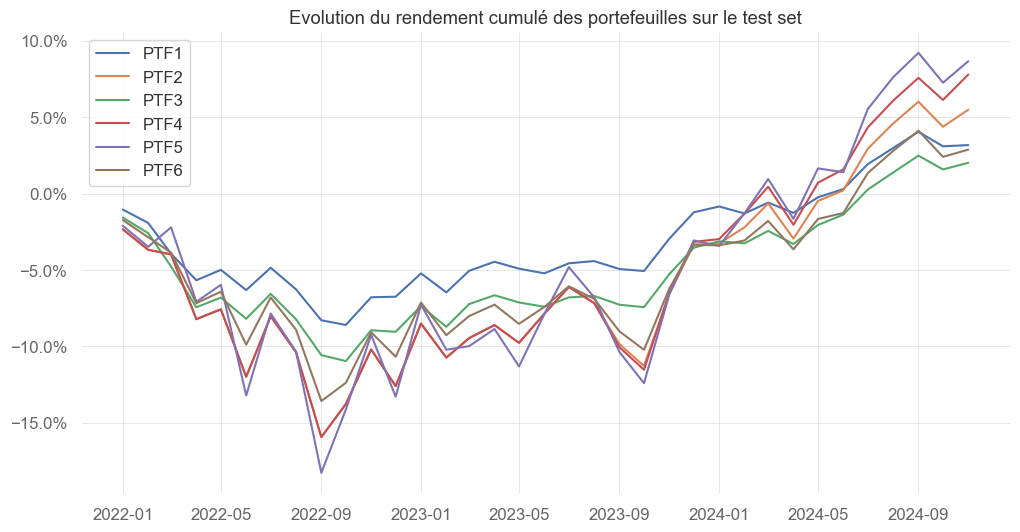

<Figure size 1000x600 with 0 Axes>

In [25]:
cumprod_yield_df = (1 + rendement_portefeuille_test_df).cumprod() - 1 
# plot 
fig = plt.figure(figsize=(12, 6))
plt.plot(cumprod_yield_df)
plt.title('Evolution du rendement cumulé des portefeuilles sur le test set')
plt.legend(cumprod_yield_df.columns)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()
plt.tight_layout()
fig.savefig('figures/4_3_evolution_portefeuilles.png')



/var/folders/zy/ycwjsmz943s7ly3gn8lrp_v00000gn/T/ipykernel_5077/3608302999.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=45)
/var/folders/zy/ycwjsmz943s7ly3gn8lrp_v00000gn/T/ipykernel_5077/3608302999.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=45)
/var/folders/zy/ycwjsmz943s7ly3gn8lrp_v00000gn/T/ipykernel_5077/3608302999.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=45)
/var/folders/zy/ycwjsmz943s7ly3gn8lrp_v00000gn/T/ipykernel_5077/3608302999.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks

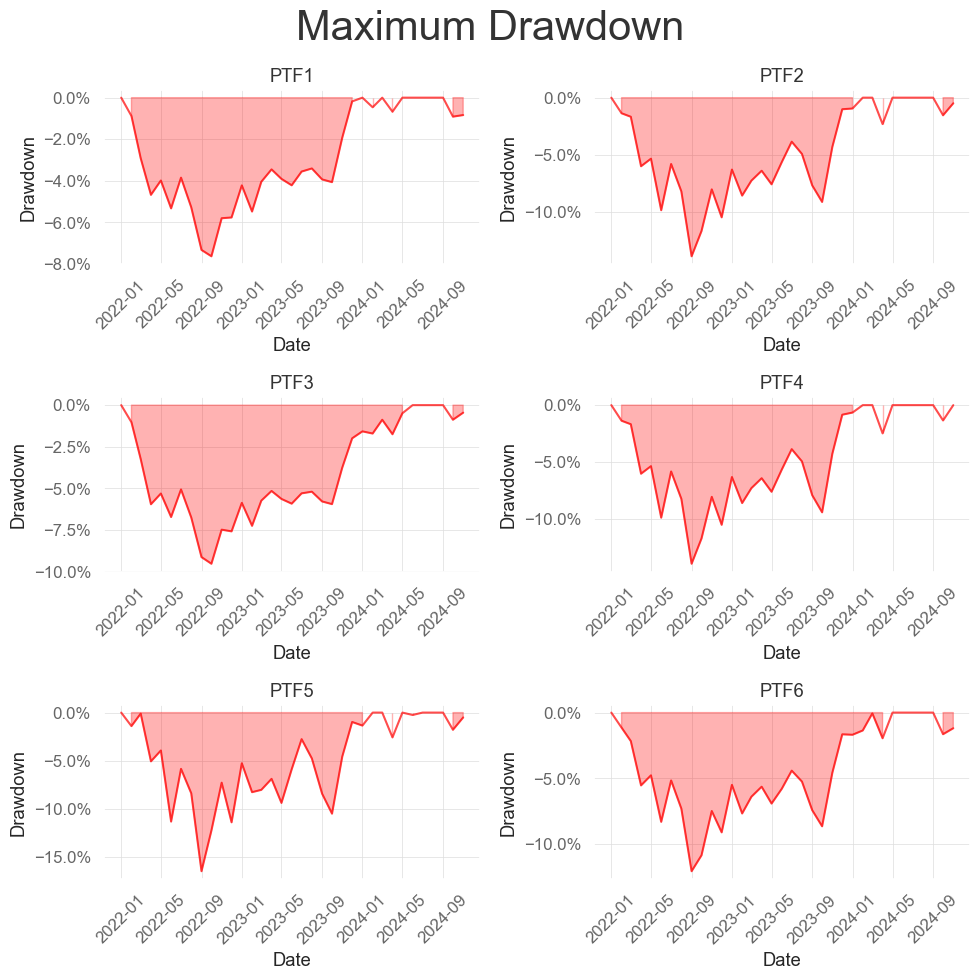

In [26]:
def plot_max_drawdown(returns, ligne, colonne, same_y=False):
    fig, axs = plt.subplots(ligne, colonne, figsize=(10, 10))
    for i in range(ligne):
        for j in range(colonne):
            if i * colonne + j >= returns.shape[1]:
                break
            series = returns.iloc[:, i * colonne + j]
            drawdown_details = qs.stats.to_drawdown_series(series)
            
            drawdown_details = drawdown_details.astype(float).dropna()
            
            axs[i, j].plot(drawdown_details.index, drawdown_details, color='red', alpha=0.7)

            # Colorier les zones en dessous de zéro en rouge et les zones au-dessus de zéro en vert
            axs[i, j].fill_between(drawdown_details.index, drawdown_details, 0, where=drawdown_details < 0, color='red', alpha=0.3)

            axs[i, j].set_title(returns.columns[i * colonne + j])
            # set le y entre 0 et -0.7
            if same_y:
                axs[i, j].set_ylim(-0.7, 0.01)
            # yaxis en percentage
            axs[i, j].yaxis.set_major_formatter(mtick.PercentFormatter(1))
            # x axis label
            # x label 45 
            axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=45)
            axs[i, j].set_xlabel('Date')
            axs[i, j].set_ylabel('Drawdown')
    # title pour le plot entier
    plt.suptitle('Maximum Drawdown', fontsize=30)
    plt.tight_layout()
    plt.show()
    fig.savefig('figures/4_3_maximum_drawdown.png')
    
plot_max_drawdown(rendement_portefeuille_test_df, ligne=3, colonne=2, same_y=False)